In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import ParameterGrid

In [47]:
data = pd.read_csv(r"D:\Du An\Data FLow\v1\data\FORECASTING BUSINESS PERFORMANCE.csv")
                   #, parse_dates=['Date'])
#data = data.sort_values('Date')

In [48]:
# --- Data Processing Section ---
def process_data(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    if df['Date'].isnull().any():
        print("Warning: Some dates could not be parsed. Dropping invalid rows.")
        df = df.dropna(subset=['Date'])

    for col in ['Units', 'Revenue', 'COGS']:
        if df[col].dtype == 'object':
            df[col] = df[col].replace({r'\$': '', ',': ''}, regex=True).str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Converted {col} to numeric.")
        if df[col].isnull().any():
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
            print(f"Filled missing {col} with median: {median_value}")

    initial_rows = len(df)
    df = df.drop_duplicates()
    if len(df) < initial_rows:
        print(f"Removed {initial_rows - len(df)} duplicate rows.")

    if (df['Units'] < 0).any() or (df['Revenue'] < 0).any():
        print("Warning: Negative Units or Revenue detected. Clamping to 0.")
        df['Units'] = df['Units'].clip(lower=0)
        df['Revenue'] = df['Revenue'].clip(lower=0)

    df = df.sort_values('Date')
    df_agg = df.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

    df_agg['Units_lag1'] = df_agg['Units'].shift(1)
    df_agg['Units_ma7'] = df_agg['Units'].rolling(window=7, min_periods=1).mean()
    df_agg['Revenue_lag1'] = df_agg['Revenue'].shift(1)
    df_agg['Revenue_ma7'] = df_agg['Revenue'].rolling(window=7, min_periods=1).mean()
    df_agg = df_agg.dropna()

    return df, df_agg

In [49]:
# Process the data
data, data_agg = process_data(data)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2256\2891794128.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Converted Revenue to numeric.
Filled missing Revenue with median: 4724.37
Converted COGS to numeric.
Removed 38 duplicate rows.


In [50]:
# Split data into train and test (80% train, 20% test)
train_size = int(len(data_agg) * 0.8)
train_data = data_agg[:train_size]
test_data = data_agg[train_size:]

In [51]:
# --- Define evaluation metrics ---
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R²': r2, 'MAPE': mape, 'RMSE': rmse}

In [52]:
# --- Model 1: ARIMA with Parameter Optimization ---
def arima_model(series, forecast_steps=12):
    best_aic = float('inf')
    best_order = None
    param_grid = {'p': range(0, 3), 'd': range(0, 2), 'q': range(0, 3)}
    
    for params in ParameterGrid(param_grid):
        try:
            model = ARIMA(series, order=(params['p'], params['d'], params['q']))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (params['p'], params['d'], params['q'])
        except:
            continue
    
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    model = ARIMA(series, order=best_order)
    results = model.fit()
    forecast = results.forecast(steps=forecast_steps)
    test_pred = results.predict(start=test_data.index[0], end=test_data.index[-1])
    return test_pred, forecast

In [53]:
# --- Model 2: LSTM with Parameter Optimization ---
def lstm_model(series, forecast_steps=12):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    def create_dataset(dataset, look_back):
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(y)
    
    param_grid = {
        'look_back': [3, 5, 7],
        'units': [50, 100],
        'learning_rate': [0.001, 0.01]
    }
    best_rmse = float('inf')
    best_params = None
    best_model = None
    best_test_pred = None
    
    for params in ParameterGrid(param_grid):
        X, y = create_dataset(scaled_data, params['look_back'])
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        model = Sequential([
            Input(shape=(params['look_back'], 1)),
            LSTM(params['units'], return_sequences=True),
            LSTM(params['units']),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, 
                  callbacks=[early_stopping], verbose=0)
        
        test_pred = model.predict(X_test)
        test_pred = scaler.inverse_transform(test_pred)
        y_test_inv = scaler.inverse_transform([y_test]).T[:len(test_pred)]
        rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
            best_test_pred = test_pred
    
    print(f"Best LSTM params: {best_params} with RMSE: {best_rmse}")
    last_sequence = scaled_data[-best_params['look_back']:].reshape((1, best_params['look_back'], 1))
    forecast = []
    for _ in range(forecast_steps):
        next_pred = best_model.predict(last_sequence, verbose=0)
        forecast.append(next_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = next_pred[0, 0]
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    
    return best_test_pred, forecast

In [54]:
# --- Model 3: Prophet with Parameter Optimization ---
def prophet_model(df, forecast_steps=12):
    prophet_df = df.rename(columns={'Date': 'ds', 'Units': 'y'})[['ds', 'y']]
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.1, 0.5],
        'seasonality_prior_scale': [1.0, 10.0]
    }
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    for params in ParameterGrid(param_grid):
        model = Prophet(
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale']
        )
        model.fit(prophet_df[:train_size])
        test_dates = test_data.rename(columns={'Date': 'ds'})[['ds']]
        test_pred = model.predict(test_dates)['yhat'].values
        rmse = np.sqrt(mean_squared_error(test_data['Units'][:len(test_pred)], test_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    print(f"Best Prophet params: {best_params} with RMSE: {best_rmse}")
    future = best_model.make_future_dataframe(periods=forecast_steps, freq='M')
    forecast = best_model.predict(future)['yhat'].tail(forecast_steps).values
    test_pred = best_model.predict(test_data.rename(columns={'Date': 'ds'})[['ds']])['yhat'].values
    return test_pred, forecast

In [55]:
# --- Model 4: XGBoost with Parameter Optimization ---
def xgboost_model(df, forecast_steps=12):
    def create_features(df, lag=3):
        df = df.copy()
        for i in range(1, lag + 1):
            df[f'lag_{i}'] = df['Units'].shift(i)
        return df.dropna()
    
    df_processed = create_features(df)
    if len(df_processed) < 4:  # Ensure enough data after lagging
        raise ValueError("Not enough data after feature creation. Increase dataset size or reduce lag.")
    
    # Recalculate train_size based on processed data
    train_size_processed = int(len(df_processed) * 0.8)
    if train_size_processed == 0 or len(df_processed) - train_size_processed == 0:
        raise ValueError("Train or test set is empty after processing. Check data length.")
    
    X = df_processed.drop(['Units', 'Revenue', 'Date'], axis=1)
    y = df_processed['Units']
    X_train, X_test = X[:train_size_processed], X[train_size_processed:]
    y_train, y_test = y[:train_size_processed], y[train_size_processed:]
    
    print(f"XGBoost: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    for params in ParameterGrid(param_grid):
        model = xgb.XGBRegressor(
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth']
        )
        model.fit(X_train, y_train)
        test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    print(f"Best XGBoost params: {best_params} with RMSE: {best_rmse}")
    test_pred = best_model.predict(X_test)
    last_features = df_processed.iloc[-1].drop(['Units', 'Revenue', 'Date']).values.reshape(1, -1)
    forecast = []
    for _ in range(forecast_steps):
        next_pred = best_model.predict(last_features)
        forecast.append(next_pred[0])
        last_features = np.roll(last_features, -1)
        last_features[0, -1] = next_pred[0]
    
    return test_pred, forecast

In [56]:
# --- Train and forecast for Units ---
models = {
    'ARIMA': arima_model(train_data['Units']),
    'LSTM': lstm_model(train_data['Units']),
    'Prophet': prophet_model(train_data),
    'XGBoost': xgboost_model(train_data)
}

results = {}
for name, (test_pred, forecast) in models.items():
    metrics = evaluate_model(test_data['Units'][:len(test_pred)], test_pred)
    results[name] = {'Test Metrics': metrics, 'Forecast': forecast}

c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA order: (2, 1, 2) with AIC: 47617.33172604178


c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Best LSTM params: {'learning_rate': 0.01, 'look_back': 7, 'units': 50} with RMSE: 122.8672107223785


15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] done processing
15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0} with RMSE: 130.46154142384435


c:\Users\ADMIN\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


XGBoost: X_train shape: (2718, 7), X_test shape: (680, 7)
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} with RMSE: 104.50594625836041


In [57]:
# --- Display Results ---
print("\nModel Performance Comparison (Units):")
for model, res in results.items():
    print(f"\n{model}:")
    print(f"R²: {res['Test Metrics']['R²']:.4f}")
    print(f"MAPE: {res['Test Metrics']['MAPE']:.4f}")
    print(f"RMSE: {res['Test Metrics']['RMSE']:.4f}")
    print(f"Forecast for next year: {res['Forecast']}")


Model Performance Comparison (Units):

ARIMA:
R²: -0.2245
MAPE: 1.4432
RMSE: 145.0522
Forecast for next year: 3401    90.039988
3402    87.214508
3403    86.149135
3404    85.515559
3405    85.029687
3406    84.624547
3407    84.279199
3408    83.983215
3409    83.729208
3410    83.511154
3411    83.323951
3412    83.163230
Name: predicted_mean, dtype: float64

LSTM:
R²: -0.0436
MAPE: 2.4732
RMSE: 132.8071
Forecast for next year: [[128.14552 ]
 [122.32884 ]
 [136.29933 ]
 [128.8482  ]
 [ 98.00447 ]
 [ 85.559166]
 [128.37186 ]
 [151.44087 ]
 [163.63185 ]
 [174.75961 ]
 [157.76631 ]
 [129.827   ]]

Prophet:
R²: 0.0095
MAPE: 1.8828
RMSE: 130.4615
Forecast for next year: [121.93076423 208.92496673 168.90260787 315.73838113 161.13299177
 121.18247159 173.46660774  46.06184615 105.29460701  72.96068029
  83.02650264  97.63879849]

XGBoost:
R²: -0.2380
MAPE: 2.0730
RMSE: 144.6040
Forecast for next year: [156.4595, 914.5204, 267.39935, -202.6974, 249.81487, 134.50923, 162.56798, 1224.0638, -3

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2256\30823552.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=data_agg['Date'].iloc[-1], periods=13, freq='M')[1:],


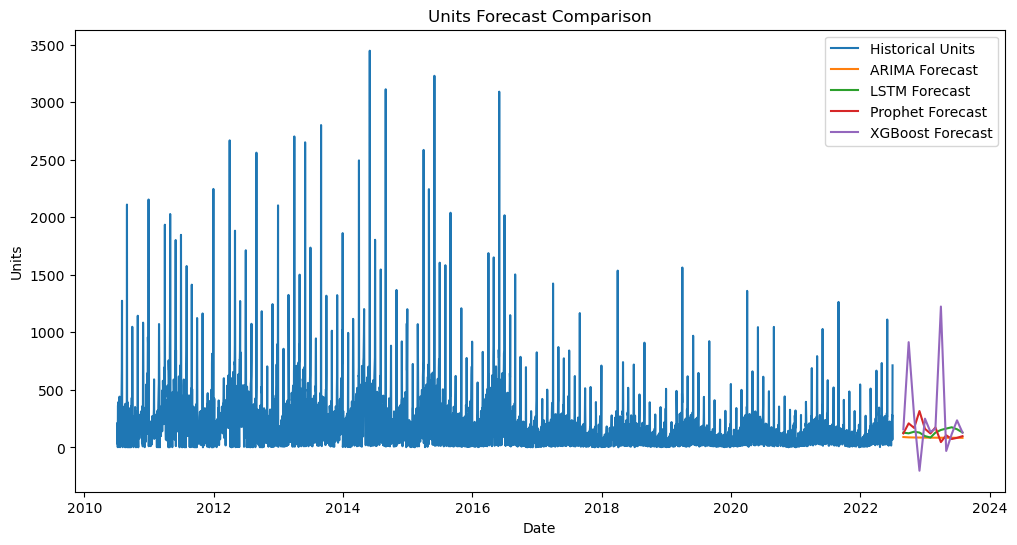

In [58]:
# --- Plot Forecasts ---
plt.figure(figsize=(12, 6))
plt.plot(data_agg['Date'], data_agg['Units'], label='Historical Units')
for name, res in results.items():
    plt.plot(pd.date_range(start=data_agg['Date'].iloc[-1], periods=13, freq='M')[1:], 
             res['Forecast'], label=f'{name} Forecast')
plt.title('Units Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.show()